### Takes in xlsx file with tabs, calculates correlation moving averages for 20 years, does some groupby visualizations.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xlrd #needed for getting xlsx sheet names
import datetime
from IPython.display import Image
import numpy as np
%run ../helperFunctions/helperFunctions.ipynb #loads defs from other file,cleaner code 
%matplotlib inline
plt.style.use('seaborn-whitegrid')
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='b')

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [22]:
def fromXLSXtoDF(sheetNames_param, xlsxData_param):
    allDF = []
    for counter, i in enumerate(sheetNames_param):
        # print the sheet name (not necessary) but print statements give valuable feedback to the programmer and are used everywhere 
        # in the development process.
        print("Reading in sheet:", i)
        
        # read each sheet named "i", and grab only columns 0 and 5 (which contain the relevant data)
        df = pd.read_excel(xlsxData_param, sheet_name=i, usecols=[0, 5])
        
        # add original sheet number and sheet name
        df["sheetNo"]   = counter
        df["sheetName"] = i 
        
        # set the timestamp to the index, this makes time series analysis easier.
        df = df.set_index("Date")
        
        # include day of year
        df["DayOfYear"] = df.index.dayofyear
        
        # calculate diff and percent change, should be done per year
        # diff is the first difference, so the change in data from one day to the next.  
        df["PremiumDiff"] = df["Premium"].diff(1)
        # percent change is the change from one day to the next.
        df["PremiumPrctChange"] = df["Premium"].pct_change(1)
        
        # drop missing values from each sheet
        df = df.dropna()
        
        print("Rows and columns:", df.shape)
        
        # add row number for each sheet, 1 to number of rows in sheet
        df['RowNumber'] = np.arange(len(df))
        
        # combine the newly created dataframe to the list of dataframes
        allDF.append(df)
    
    # concatenate across column (axis=0), use the index as key)
    result = pd.concat(allDF, axis=0, join='outer')
    # change names of columns to the sheetnames
    # result.columns = sheetNames
    return(result)

def getSheetNames(xlsxData_param):
    xls = xlrd.open_workbook(xlsxData_param, on_demand=True)
    return(xls.sheet_names())

The code below takes the required names of the Excel sheets and the Excel file and runs the function fromXLSXtoDF defined in the above function.

In [23]:
# Execute the above functions
sheetNames = getSheetNames('../../data/raw/Pna_Prem_Upload_Sheet_no_empty_rows.xlsx')

# Read in the name of the Excel file
xlsxData = '../../data/raw/Pna_Prem_Upload_Sheet_no_empty_rows.xlsx'

# Run the function
sbYears = fromXLSXtoDF(sheetNames, xlsxData)

# Store and take a look at data
# sbYears.to_csv("../../data/processed/pnaAll.csv")

Reading in sheet: Pna Feb17
Rows and columns: (159, 6)
Reading in sheet: Pna Mar17
Rows and columns: (174, 6)
Reading in sheet: Pna Apr17
Rows and columns: (200, 6)
Reading in sheet: Pna May17
Rows and columns: (219, 6)
Reading in sheet: Pna Jun17
Rows and columns: (246, 6)
Reading in sheet: Pna Jul17
Rows and columns: (258, 6)
Reading in sheet: Pna Aug17
Rows and columns: (60, 6)
Reading in sheet: Pna Feb18
Rows and columns: (148, 6)
Reading in sheet: Pna Mar18
Rows and columns: (166, 6)
Reading in sheet: Pna Apr18
Rows and columns: (183, 6)
Reading in sheet: Pna May18
Rows and columns: (207, 6)
Reading in sheet: Pna Jun18
Rows and columns: (187, 6)
Reading in sheet: Pna Jul18
Rows and columns: (212, 6)
Reading in sheet: Pna Aug18
Rows and columns: (110, 6)
Reading in sheet: Pna Sep18
Rows and columns: (85, 6)
Reading in sheet: Pna Oct18
Rows and columns: (85, 6)
Reading in sheet: Pna Nov18
Rows and columns: (11, 6)
Reading in sheet: Pna Dec18
Rows and columns: (6, 6)
Reading in sheet

In [24]:
#Read in BRL dta

#Read in data from the same Excel file in sheet named 'Brl'
brl = pd.read_excel('../../data/raw/Pna Prem vs Brl - Jeff.xlsx', 'Brl')

#Set Date (GMT) as the index, which makes times series analysis easier
brl = brl.set_index('Date (GMT)')

#Re-naming index to Date in order to merge 
brl.index.name = 'Date' 

#Calculate the percentage change, just like in the function 
brl['BrlPrctChange'] = brl["Last"].pct_change(1)

#Calculate the first differeence, just like in the function
brl['BrlDiff'] = brl["Last"].diff(1)

#Take only the relevant columns of the Pandas dataframe
brl = brl[["Last", "BrlDiff", "BrlPrctChange"]]

#Rename the columns called Last to Brl
brl = brl.rename(columns = {'Last':'Brl'})

#Drop missing values
brl = brl.dropna()

#Show me the results
brl.head(3)

,Brl,BrlDiff,BrlPrctChange
Date,,,
2015-07-08,3.2335,0.0472,0.014813
2015-07-09,3.2188,-0.0147,-0.004546
2015-07-10,3.1583,-0.0605,-0.018796


In [25]:
# Merge data
merge1 = pd.merge(sbYears,brl,how='inner',on='Date')
merge1.sort_values(by=['sheetNo', 'Date'], inplace = True)
# merge1.to_csv("tmp.csv")

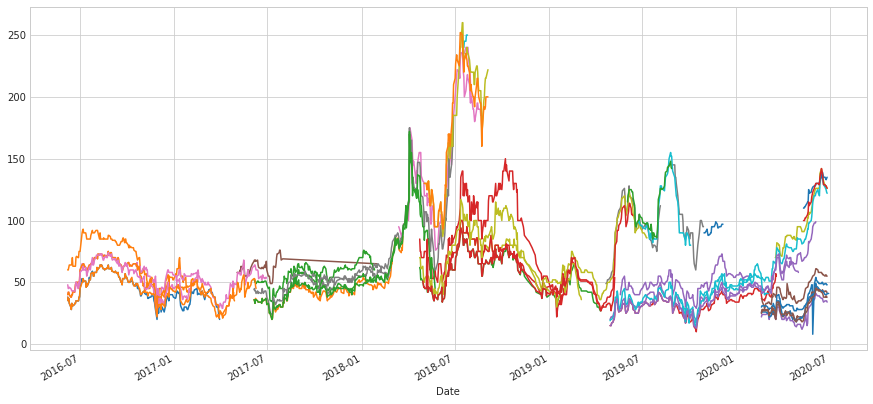

In [26]:
# Plot grouped by data
df1 = sbYears[["Premium", "sheetName"]]
fig, ax = plt.subplots(figsize=(15,7))
bp = df1.groupby('sheetName').plot(ax=ax, legend=False)

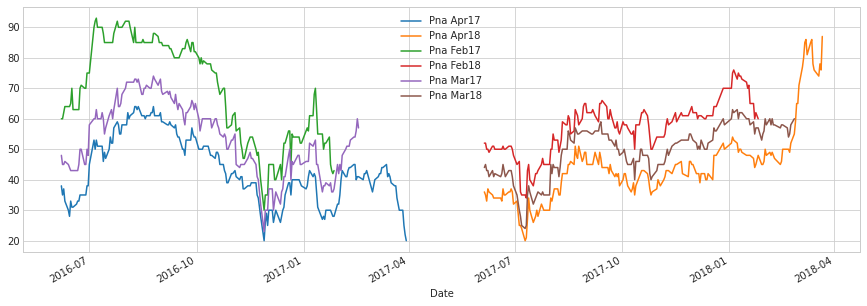

In [27]:
# Select which sheets (date) select indices (sheet 0,10,23) by name, monthly 
def plotSelected_Date(data1, dates1):   
    selectedDates = data1.loc[data1['sheetName'].isin(dates1)]
    fig, ax = plt.subplots(figsize=(15,5))
    selectedDates.groupby('sheetName')["Premium"].plot(ax=ax, legend=True)    

dates = ['Pna Feb17', 'Pna Mar17', 'Pna Apr17', 'Pna Feb18', 'Pna Mar18', 'Pna Apr18', ]
df1 = sbYears[["Premium", "sheetName"]]
plotSelected_Date(df1, dates)  

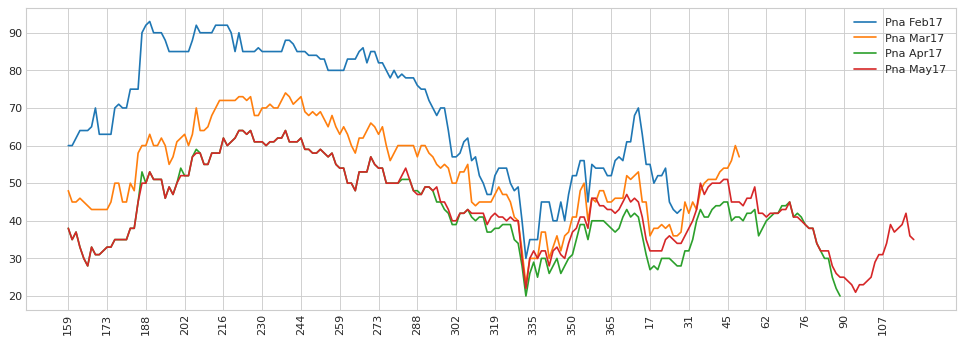

In [28]:
# Select which sheets (date) select indices (sheet 0,10,23) by name, monthly 
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='b')
def plotSelected_Days(data1, dates1):   
    selectedDates = data1.loc[data1['sheetName'].isin(dates1)]
    grp = selectedDates.groupby('sheetName')
    for i in dates1:
        t1 = grp.get_group(i)
        x = t1.DayOfYear.astype(str) #string necessary to draw xaxis (int will order lowest to highest)
        y = t1.Premium
        plt.plot(x,y, label = i)
     
    plt.xticks(x[::10],  rotation='vertical')
    plt.legend()
    plt.show()
                
dates = ['Pna Feb17', 'Pna Mar17',  'Pna Apr17', 'Pna May17']
df1 = sbYears[["Premium", "sheetName", "DayOfYear"]]
plotSelected_Days(df1, dates)    
    

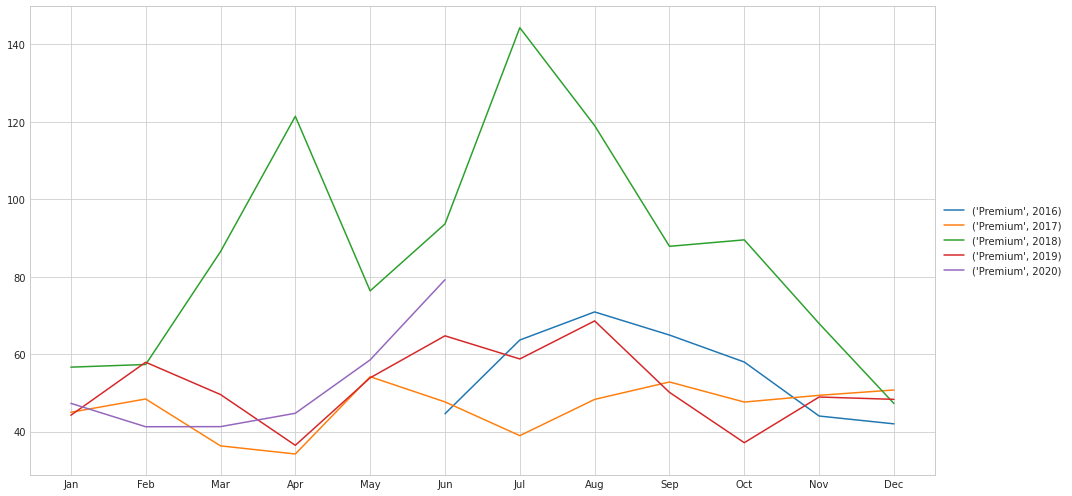

In [29]:
# Plot over years
df1 = df1.drop("DayOfYear", axis = 1)
pt = pd.pivot_table(df1, index=df1.index.month, columns=df1.index.year, aggfunc='mean')

ax = plt.figure(figsize=(15,7)).add_subplot(111)
ax.plot(pt)

ticklabels = [datetime.date(1900, item, 1).strftime('%b') for item in pt.index]
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(ticklabels) #add monthlabels to the xaxis

ax.legend(pt.columns.tolist(), loc='center left', bbox_to_anchor=(1, .5)) #add the column names as legend.
plt.tight_layout(rect=[0, 0, 1, 1])

plt.show()

################### pick out per day per month ######################

In [30]:
# compare to the Brazilian prices like last time corr()
# select large moving days

In [31]:
# for a given start date, select all years
df1 = sbYears[["RowNumber", "Premium", "sheetName", "DayOfYear"]]
df1

,RowNumber,Premium,sheetName,DayOfYear
Date,,,,
2016-06-07,0,60.0,Pna Feb17,159
2016-06-08,1,60.0,Pna Feb17,160
2016-06-09,2,62.0,Pna Feb17,161
2016-06-10,3,64.0,Pna Feb17,162
2016-06-13,4,64.0,Pna Feb17,165
...,...,...,...,...
2020-06-22,86,49.0,Pna Jul21,174
2020-06-23,87,49.0,Pna Jul21,175
2020-06-24,88,49.0,Pna Jul21,176


In [32]:
df1["day"], df1["month"], df1["year"] = df1.index.day, df1.index.month, df1.index.year
df1 

/home/jeff001/python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,RowNumber,Premium,sheetName,DayOfYear,day,month,year
Date,,,,,,,
2016-06-07,0,60.0,Pna Feb17,159,7,6,2016
2016-06-08,1,60.0,Pna Feb17,160,8,6,2016
2016-06-09,2,62.0,Pna Feb17,161,9,6,2016
2016-06-10,3,64.0,Pna Feb17,162,10,6,2016
2016-06-13,4,64.0,Pna Feb17,165,13,6,2016
...,...,...,...,...,...,...,...
2020-06-22,86,49.0,Pna Jul21,174,22,6,2020
2020-06-23,87,49.0,Pna Jul21,175,23,6,2020
2020-06-24,88,49.0,Pna Jul21,176,24,6,2020


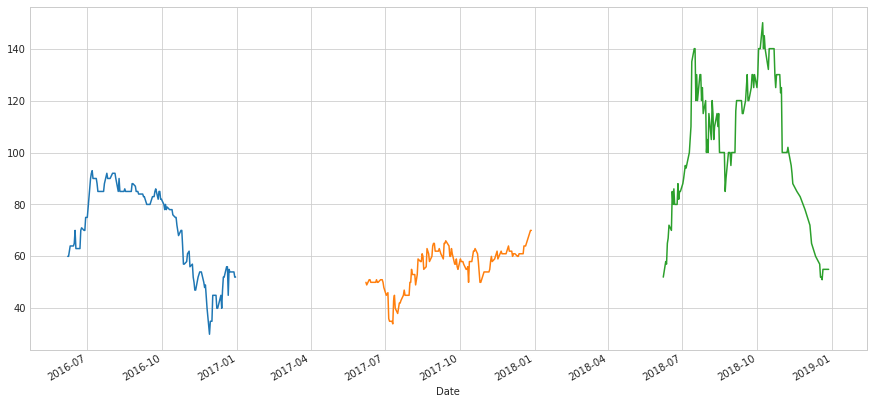

In [33]:
df2 = df1[(159 <= df1.DayOfYear) & ((df1.sheetName == "Pna Feb17") | (df1.sheetName == "Pna Feb18") | (df1.sheetName == "Pna Feb19"))] 

# Plot grouped by data
df3 = df2[["Premium", "sheetName"]]
fig, ax = plt.subplots(figsize=(15,7))
bp = df3.groupby('sheetName').plot(ax=ax, legend=False)


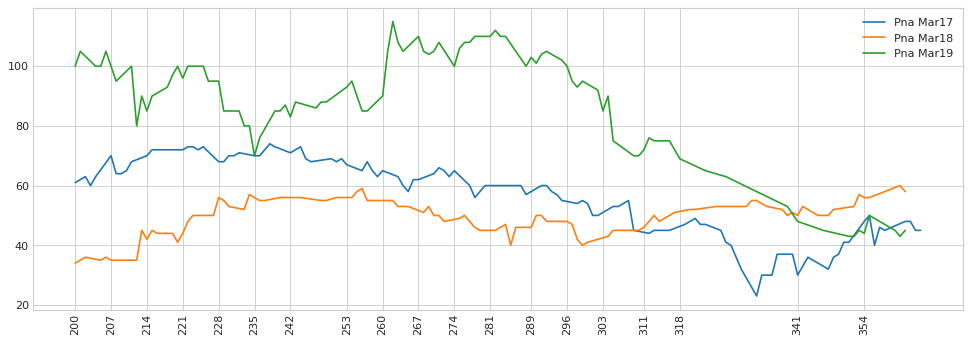

In [34]:
# NOT GOOD!!!

figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='b')

def plotSelected_Days(data1, dates1):   
    selectedDates = data1.loc[data1['sheetName'].isin(dates1)]
    grp = selectedDates.groupby('sheetName')
    for i in dates1:
        t1 = grp.get_group(i)
        x = t1.DayOfYear
        y = t1.Premium
        plt.plot(x,y, label = i)
        
    plt.xticks(x[::5], rotation='vertical')
    plt.legend()
    plt.show()

mnt1  = "Mar"
beginDay = 200

a1 = "Pna " + mnt1 + "17"   
a2 = "Pna " + mnt1 + "18"
a3 = "Pna " + mnt1 + "19"

df2 = df1[(beginDay <= df1.DayOfYear) & ((df1.sheetName == a1) | (df1.sheetName == a2) | (df1.sheetName == a3))] 
                
dates = df2["sheetName"].unique()
df3 = df2[["Premium", "sheetName", "DayOfYear"]]
plotSelected_Days(df3, dates)    

[169 172 173 174 175 176 179 180 181 182 183 187 188 189 190 193 194 195
 196 197 200 201 202 203 204 207 208 209 210 211 214 215 216 217 218 221
 222 223 224 225 228 229 230 231 232 235 236 237 238 239 242 243 244 245
 246 250 251 252 253 256 257 258 259 260 263 264 265 266 267 270 271 272
 273 274 277 278 279 280 281 284 285 287 288 291 292 293 294 295 298 299
 300 301 302 305 306 308 309 312 313 314 315 316 319 321 322 323 326 327
 328 330 333 334 335 336 337 340 341 342 343 347 348 349 350 351 354 355
 356 357 358 362 363 364 365   3   4   5   6   9  10  11  12  13  17  18
  19  20  23  24  25  26  27  30  31  32  33  34  37  38  39  40  41  44
  45  46  47  48]
[170 171 172 173 174 177 178 179 180 181 184 186 187 188 191 192 193 194
 195 198 199 200 201 202 205 206 207 208 209 212 213 214 215 216 219 220
 221 222 223 226 227 228 229 230 233 234 235 236 237 240 241 242 243 244
 248 249 251 254 255 256 257 261 262 263 264 265 268 269 270 271 272 275
 276 277 278 279 282 283 284 285 

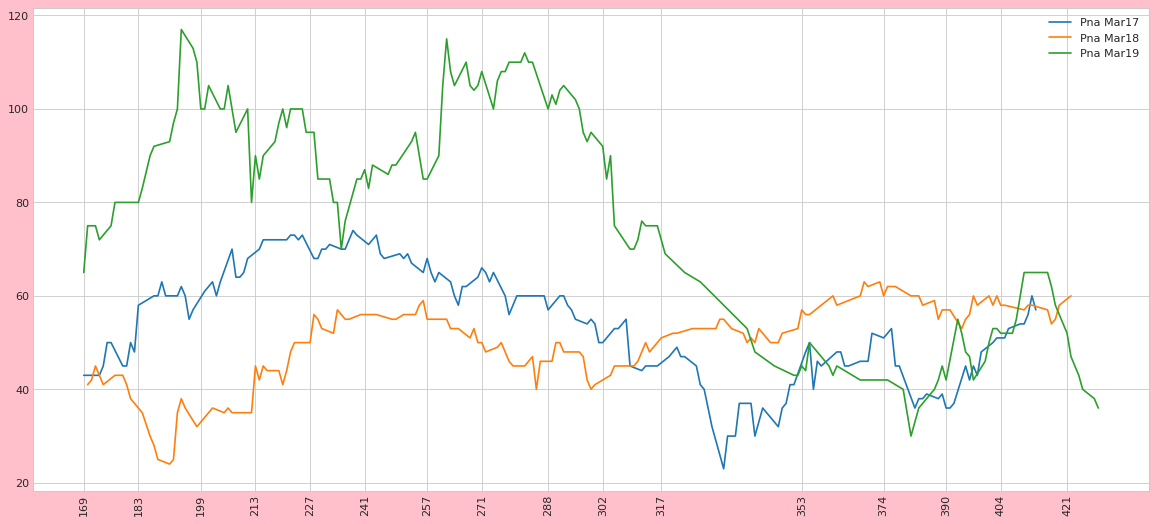

In [37]:
# Function to compare time series over one or more years by looking at an observation's day of the year.  
# For example, compare data from February 2017 and February 2018 using the closest starting day of the year.
# Time series cross years, so days over 365 are summed.  For example, Dec 31st 2017 is 365, Jan. 1st 2018 is 366, Jan. 2nd is 367...
# The function closest is needed because not all days are available in all years, so day 206 in 2017 might not be available in 2018, 
#   so closest chooses the closest day to 206 in 2017.

figure(num=None, figsize=(18, 8), dpi=80, facecolor='pink', edgecolor='black')

def closest(lst, aim1):   
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-aim1))] 

def plotSelected_Days(data1, dates1, beginDay1):   
    selectedDates = data1.loc[data1['sheetName'].isin(dates1)]
    grp = selectedDates.groupby('sheetName')
    for i in dates1:
        oneGrp = grp.get_group(i)
        values1 = oneGrp["DayOfYear"].values
        # get closest day to chosen begin day of year
        beginHere = closest(values1, beginDay1)
        rowNum = list(oneGrp["DayOfYear"].values).index(beginHere)
        # x is the x value of plot(x,y)
        x = oneGrp.iloc[rowNum:,]["DayOfYear"].values
        print(x)
        
        # mxVal is the last day of the year, might not be 365 or 366!
        mxVal = max(x)
        # get index of last day of year, the value won't work
        strt = list(x).index(mxVal) 
        # take those days of year greater than 365 of previous year and add day of the year of the new year.
        for q in range((strt+1), len(x)):
            x[q] = x[q] + 365
        
        # y is y of plot(x,y)
        y = oneGrp.iloc[rowNum:,]["Premium"]
        plt.plot(x,y, label = i)    
    plt.xticks(x[::10], rotation='vertical')
    plt.legend()
    plt.show()

beginDay1 = 169
dates1 = ["Pna Mar17", "Pna Mar18", "Pna Mar19"]
plotSelected_Days(df1, dates1, beginDay1)        
    

In [16]:
def corrWindow(prem_param, brl_param, mvWindows):
    corrMv = []
    for i in range(0,prem1.size - mvWindows):
        cor1 = prem_param[i:i+mvWindows].corr(brl_param[i:i+mvWindows])
        corrMv.append(cor1)

    #reindex using subset of the dates
    df = pd.DataFrame({'moving_Corr': corrMv},
                  index = prem1.index[0:prem1.size - mvWindows])    
    return(df)

In [40]:
merge1.head()

,Premium,sheetNo,sheetName,DayOfYear,PremiumDiff,PremiumPrctChange,RowNumber,Brl,BrlDiff,BrlPrctChange
Date,,,,,,,,,,
2016-06-07,60.0,0,Pna Feb17,159,5.0,0.090909,0,3.4410,-0.0475,-0.013616
2016-06-08,60.0,0,Pna Feb17,160,0.0,0.000000,1,3.3615,-0.0795,-0.023104
2016-06-09,62.0,0,Pna Feb17,161,2.0,0.033333,2,3.3995,0.0380,0.011304
2016-06-10,64.0,0,Pna Feb17,162,2.0,0.032258,3,3.4175,0.0180,0.005295
2016-06-13,64.0,0,Pna Feb17,165,0.0,0.000000,4,3.4817,0.0642,0.018786


In [58]:
mr1 = merge1[merge1["sheetName"] == "Pna Feb17"]
mr1

,Premium,sheetNo,sheetName,DayOfYear,PremiumDiff,PremiumPrctChange,RowNumber,Brl,BrlDiff,BrlPrctChange
Date,,,,,,,,,,
2016-06-07,60.0,0,Pna Feb17,159,5.0,0.090909,0,3.4410,-0.0475,-0.013616
2016-06-08,60.0,0,Pna Feb17,160,0.0,0.000000,1,3.3615,-0.0795,-0.023104
2016-06-09,62.0,0,Pna Feb17,161,2.0,0.033333,2,3.3995,0.0380,0.011304
2016-06-10,64.0,0,Pna Feb17,162,2.0,0.032258,3,3.4175,0.0180,0.005295
2016-06-13,64.0,0,Pna Feb17,165,0.0,0.000000,4,3.4817,0.0642,0.018786
...,...,...,...,...,...,...,...,...,...,...
2017-01-23,54.0,0,Pna Feb17,23,2.0,0.038462,154,3.1628,-0.0057,-0.001799
2017-01-24,45.0,0,Pna Feb17,24,-9.0,-0.166667,155,3.1697,0.0069,0.002182
2017-01-25,43.0,0,Pna Feb17,25,-2.0,-0.044444,156,3.1697,0.0000,0.000000


In [111]:
def corrWindowBigMovers(data1, rangeComparison, series1, series2, mvWindows, rangeLimits, minimumNumberforCorr):
    corrMv = []
    
    # select only values great or less than specified value
    # look at only large movers
    data2 = data1[np.abs(data1[rangeComparison]) > rangeLimits]
    prem_param = data2[series1] 
    brl_param  = data2[series2] 

    for i in range(0,prem1.size - mvWindows):
        cor1 = prem_param[i:i+mvWindows].corr(brl_param[i:i+mvWindows], min_periods = minimumNumberforCorr)
        corrMv.append(cor1)

    #reindex using subset of the dates
    df = pd.DataFrame({'moving_Corr': corrMv},
                  index = prem1.index[0:prem1.size - mvWindows])    
    howMany = df.dropna()
    print("Shape of reduced dataframe:", howMany.shape)
    return(df)

Shape of reduced dataframe: (103, 1)


/home/jeff001/python36/lib/python3.6/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/jeff001/python36/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,moving_Corr
Date,
2018-06-05,0.154232
2018-06-06,0.352072
2018-06-07,0.310861
2018-06-08,0.426679
2018-06-11,0.738908


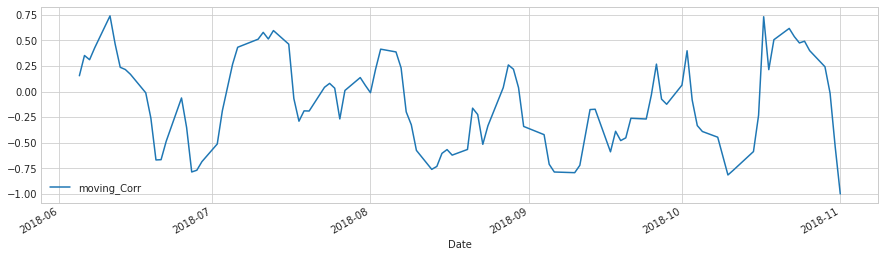

In [124]:
# Run the code above on the premium and Brazil data.
df1 = merge1[merge1["sheetName"] == "Pna Feb18"]

rangeLimits = .01        #smaller values will include more data
moveWindows = 10         #number of correlation periods
rangeComparison = "PremiumPrctChange"  #which column do you use to set the limits of comparision
series1 = "Premium"      #which columns do you want to compare
series2 = "Brl"
minimumNumberforCorr = 1 #number of values need to run correlation
    
df = corrWindowBigMovers(df1, rangeComparison, series1, series2, moveWindows, rangeLimits, minimumNumberforCorr)    
df.plot(figsize=(15,4))        
df.dropna().head(5)